In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from typing import List

# Load csv data into a dataframe
# df = pd.read_csv('chile_news_2019_10_01_to_2019_11_01_with_link.csv')
df = pd.read_csv('tweets_with_long_urls.csv') # Read in previously lengthened urls
print(df.shape)
df.head()

(36698, 7)


Unnamed: 0            User              TweetCreated              TweetId   
0           0  meganoticiascl  2019-10-31T23:37:59.000Z  1190050315481100293  \
1           1  meganoticiascl  2019-10-31T23:06:40.000Z  1190042433117024256   
2           2  meganoticiascl  2019-10-31T23:03:55.000Z  1190041740457250816   
3           3  meganoticiascl  2019-10-31T22:38:04.000Z  1190035237050474497   
4           4  meganoticiascl  2019-10-31T22:21:32.000Z  1190031075885690881   

                                                Link   
0  https://twitter.com/meganoticiascl/status/1190...  \
1  https://twitter.com/meganoticiascl/status/1190...   
2  https://twitter.com/meganoticiascl/status/1190...   
3  https://twitter.com/meganoticiascl/status/1190...   
4  https://twitter.com/meganoticiascl/status/1190...   

                                            Contents   
0  Manifestantes con disfraces se toman la marcha...  \
1  🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo...   
2  Marcelo Salas y movilizaciones sociales: "Lo q...   
3  Nueva jornada de masivas marchas en Santiago y...   
4  Sismo afecta a la zona central del país\n\nhtt...   

                                   Contents_Long_Url  
0  Manifestantes con disfraces se toman la marcha...  
1  🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo...  
2  Marcelo Salas y movilizaciones sociales: "Lo q...  
3  Nueva jornada de masivas marchas en Santiago y...  
4  Sismo afecta a la zona central del país\n\nhtt...

In [2]:
import pandas as pd
import re
from unshortenit import UnshortenIt
from cachetools import cached, LRUCache
from tqdm import tqdm

# This uses a regex from stackoverflow: https://stackoverflow.com/a/48769624

# Regex Explained:
# (?:(?:https?|ftp):\/\/)?: Matches the start of a URL (http, https, or ftp followed by ://), but this part is optional.
# [\w/\-?=%.]+: Matches the domain name and may include parts of the path. It accepts letters, numbers, underscores, slashes, hyphens, question marks, equal signs, percent signs, and dots.
# \.: Matches a literal dot, typically preceding the top-level domain.
# [\w/\-&?=%.]+: Matches the top-level domain and can include additional path or query parameters, allowing letters, numbers, underscores, slashes, hyphens, ampersands, question marks, equal signs, percent signs, and dots.
regex_pattern = r'https?://\S+'

unshortener = UnshortenIt()

@cached(LRUCache(maxsize=40_000))
def unshorten_url(url):
    """
    Expands a shortened URL to its original form, using caching to improve efficiency.

    This function uses the UnshortenIt library to expand shortened URLs (e.g., 't.co' links).
    The results are cached in an LRU (Least Recently Used) cache to optimize performance for
    repeated requests of the same URL.

    Args:
    - url (str): The shortened URL to be expanded.

    Returns:
    - str: The original, expanded URL. If unshortening fails, returns the original shortened URL.

    The cache can store up to 10,000 entries. When the cache's capacity is reached, the least recently
    used entries are discarded to make space for new ones.
    """
    try:
        return unshortener.unshorten(url)
    except Exception as e:
        print(f"Error unshortening URL {url}: {e}")
        return url

def replace_shortened_urls(text):
    """
    Replaces all shortened URLs found in the given text with their unshortened forms.

    Parameters:
    - text (str): Text containing one or more shortened URLs.

    Returns:
    - str: Text with all shortened URLs replaced by unshortened ones.
    """
    urls = re.findall(regex_pattern, text)
    for url in urls:
        unshortened_url = unshorten_url(url)

        if url == unshortened_url:
            # print(f"URL {url} could not be shortened.")
            pass
            
        else:
            # print(f"URL {url} shortened to {unshortened_url}")
            text = text.replace(url, unshortened_url)
    return text

import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def unshorten_urls_in_contents(df, max_workers=100):
    """
    Applies replace_shortened_urls to the 'Contents' column of a DataFrame using multithreading
    for improved performance and displays a detailed progress bar.

    Parameters:
    - df (pd.DataFrame): DataFrame with the 'Contents' text column containing shortened URLs.
    - max_workers (int): Maximum number of threads to use for processing.

    Returns:
    - pd.DataFrame: DataFrame with URLs in the 'Contents' replaced by their unshortened forms
                    in the new 'Contents_Long_Url' col.
    """
    # Function to apply to each row
    def process_row(row):
        return replace_shortened_urls(row.Contents)

    # Initialize the ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submitting tasks to the executor
        futures = {executor.submit(process_row, row): i for i, row in enumerate(df.itertuples())}

        # Progress bar setup and processing
        for future in tqdm(as_completed(futures), total=len(df), desc="Unshortening URLs", unit="row"):
            index = futures[future]
            try:
                # Retrieve the result and update the DataFrame
                df.at[index, 'Contents_Long_Url'] = future.result()
            except Exception as e:
                print(f"Error processing row {index}: {e}")

    return df

In [3]:
# Comment out as ths was run 
# df_long_urls = unshorten_urls_in_contents(df)
# df_long_urls.to_csv("tweets_with_long_urls.csv", index=False)
# df = df_long_urls
# df.Contents[30_000]

In [4]:
df

Unnamed: 0            User              TweetCreated   
0               0  meganoticiascl  2019-10-31T23:37:59.000Z  \
1               1  meganoticiascl  2019-10-31T23:06:40.000Z   
2               2  meganoticiascl  2019-10-31T23:03:55.000Z   
3               3  meganoticiascl  2019-10-31T22:38:04.000Z   
4               4  meganoticiascl  2019-10-31T22:21:32.000Z   
...           ...             ...                       ...   
36693       36693             T13  2019-09-30T21:37:07.000Z   
36694       36694             T13  2019-09-30T21:27:52.000Z   
36695       36695             T13  2019-09-30T21:27:18.000Z   
36696       36696             T13  2019-09-30T21:17:22.000Z   
36697       36697             T13  2019-09-30T21:10:16.000Z   

                   TweetId                                               Link   
0      1190050315481100293  https://twitter.com/meganoticiascl/status/1190...  \
1      1190042433117024256  https://twitter.com/meganoticiascl/status/1190...   
2      1190041740457250816  https://twitter.com/meganoticiascl/status/1190...   
3      1190035237050474497  https://twitter.com/meganoticiascl/status/1190...   
4      1190031075885690881  https://twitter.com/meganoticiascl/status/1190...   
...                    ...                                                ...   
36693  1178785874751971337  https://twitter.com/T13/status/117878587475197...   
36694  1178783544186937344  https://twitter.com/T13/status/117878354418693...   
36695  1178783400536236033  https://twitter.com/T13/status/117878340053623...   
36696  1178780901670604802  https://twitter.com/T13/status/117878090167060...   
36697  1178779114012119041  https://twitter.com/T13/status/117877911401211...   

                                                Contents   
0      Manifestantes con disfraces se toman la marcha...  \
1      🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo...   
2      Marcelo Salas y movilizaciones sociales: "Lo q...   
3      Nueva jornada de masivas marchas en Santiago y...   
4      Sismo afecta a la zona central del país\n\nhtt...   
...                                                  ...   
36693  Qué es el "fraude del CEO" con el que hackers ...   
36694  EN VIVO 🥇 | Comienzan los 200 metros femeninos...   
36695  Centro Sismológico explica últimos temblores r...   
36696  EN VIVO 🥇 | Arrancan los 3 mil metros con obst...   
36697  "Impeachment" a Trump: las figuras clave en la...   

                                       Contents_Long_Url  
0      Manifestantes con disfraces se toman la marcha...  
1      🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo...  
2      Marcelo Salas y movilizaciones sociales: "Lo q...  
3      Nueva jornada de masivas marchas en Santiago y...  
4      Sismo afecta a la zona central del país\n\nhtt...  
...                                                  ...  
36693  Qué es el "fraude del CEO" con el que hackers ...  
36694  EN VIVO 🥇 | Comienzan los 200 metros femeninos...  
36695  Centro Sismológico explica últimos temblores r...  
36696  EN VIVO 🥇 | Arrancan los 3 mil metros con obst...  
36697  "Impeachment" a Trump: las figuras clave en la...  

[36698 rows x 7 columns]

# URLs

## Look at top URLs in the tweets

In [5]:
df["Contents"][0]

'Manifestantes con disfraces se toman la marcha en Plaza Italia\n\nhttps://t.co/VU7aap0X5B'

In [6]:
import pandas as pd
import re

def create_url_dataframe(df, input_col="Contents_Long_Url", output_col="URL"):
    """
    Creates a new DataFrame by extracting and exploding URLs from a specified column.

    This function uses a regex to identify and extract URLs from text in the specified input column.
    Extracted URLs are placed in a new column, and the DataFrame is expanded so that each URL 
    has its own row while retaining associated data.

    Parameters:
    - df (pd.DataFrame): DataFrame with text data.
    - input_col (str): Name of the column containing text with URLs. Default is 'Contents'.
    - output_col (str): Name of the new column to store extracted URLs. Default is 'URL'.

    Returns:
    - pd.DataFrame: A new DataFrame with original columns and an additional column for extracted URLs.
    """
    # Function to extract URLs from text
    def extract_urls(text):
        return re.findall(r'https?://\S+', text)

    # Extract URLs and explode into separate rows
    df[output_col] = df[input_col].apply(extract_urls)
    df['num_urls'] = df[output_col].apply(lambda x: len(x)) # get num of urls in tweet
    df[f'original_{output_col}'] = df[output_col].copy()
    url_df = df.explode(output_col)

    # Add mark if the url is from Twitter
    url_df['twitter_url'] = url_df[output_col].apply(lambda x: 'twitter.com' in str(x))


    return url_df

# Usage example
df_url = create_url_dataframe(df)
df_url.head()


Unnamed: 0            User              TweetCreated              TweetId   
0           0  meganoticiascl  2019-10-31T23:37:59.000Z  1190050315481100293  \
1           1  meganoticiascl  2019-10-31T23:06:40.000Z  1190042433117024256   
2           2  meganoticiascl  2019-10-31T23:03:55.000Z  1190041740457250816   
3           3  meganoticiascl  2019-10-31T22:38:04.000Z  1190035237050474497   
4           4  meganoticiascl  2019-10-31T22:21:32.000Z  1190031075885690881   

                                                Link   
0  https://twitter.com/meganoticiascl/status/1190...  \
1  https://twitter.com/meganoticiascl/status/1190...   
2  https://twitter.com/meganoticiascl/status/1190...   
3  https://twitter.com/meganoticiascl/status/1190...   
4  https://twitter.com/meganoticiascl/status/1190...   

                                            Contents   
0  Manifestantes con disfraces se toman la marcha...  \
1  🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo...   
2  Marcelo Salas y movilizaciones sociales: "Lo q...   
3  Nueva jornada de masivas marchas en Santiago y...   
4  Sismo afecta a la zona central del país\n\nhtt...   

                                   Contents_Long_Url   
0  Manifestantes con disfraces se toman la marcha...  \
1  🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo...   
2  Marcelo Salas y movilizaciones sociales: "Lo q...   
3  Nueva jornada de masivas marchas en Santiago y...   
4  Sismo afecta a la zona central del país\n\nhtt...   

                                                 URL  num_urls   
0  https://www.meganoticias.cl/nacional/280814-fo...         1  \
1  https://www.pscp.tv/w/cItggDFEWkVvb25EV01FYXl8...         1   
2  https://www.meganoticias.cl/deportes/280809-ma...         1   
3  https://www.meganoticias.cl/nacional/280810-nu...         1   
4  https://www.meganoticias.cl/nacional/280812-si...         1   

                                        original_URL  twitter_url  
0  [https://www.meganoticias.cl/nacional/280814-f...        False  
1  [https://www.pscp.tv/w/cItggDFEWkVvb25EV01FYXl...        False  
2  [https://www.meganoticias.cl/deportes/280809-m...        False  
3  [https://www.meganoticias.cl/nacional/280810-n...        False  
4  [https://www.meganoticias.cl/nacional/280812-s...        False

In [7]:
# Apply Blacklist
def add_contains_blacklist_column(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    """
    Adds a 'contains_blacklist_word' column to a DataFrame indicating if the tweet text contains certain keywords.

    This function checks each entry in the specified text column against a predefined list of keywords (blacklist).
    If any of these keywords are found in the text, the corresponding row in the 'contains_blacklist_word' column is set to True.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing tweet data.
    - text_column (str): The name of the column in df that contains the tweet text.

    Returns:
    - pd.DataFrame: The original DataFrame with an additional 'contains_blacklist_word' column.
    """
    # Define the blacklist words
    blacklist: List[str] = ['envivo', 'endirecto']

    # Function to check if text contains any blacklist words
    def contains_blacklist_word(text: str, blacklist: List[str]) -> bool:
        return any(blacklist_word in text.lower() for blacklist_word in blacklist)

    # Apply the function to the specified text column
    df['contains_blacklist_word'] = df[text_column].apply(lambda text: contains_blacklist_word(text, blacklist))

    return df

df_url = add_contains_blacklist_column(df_url, 'Contents_Long_Url')
df_url["contains_blacklist_word"].value_counts()

contains_blacklist_word
False    58524
True      1478
Name: count, dtype: int64

In [8]:
# Look for tweets with multiple URLs
multiple_urls = df_url[df_url["num_urls"] > 1]
multiple_urls

Unnamed: 0            User              TweetCreated   
19             19  meganoticiascl  2019-10-31T16:43:21.000Z  \
19             19  meganoticiascl  2019-10-31T16:43:21.000Z   
20             20  meganoticiascl  2019-10-31T16:40:14.000Z   
20             20  meganoticiascl  2019-10-31T16:40:14.000Z   
21             21  meganoticiascl  2019-10-31T16:37:51.000Z   
...           ...             ...                       ...   
36695       36695             T13  2019-09-30T21:27:18.000Z   
36696       36696             T13  2019-09-30T21:17:22.000Z   
36696       36696             T13  2019-09-30T21:17:22.000Z   
36697       36697             T13  2019-09-30T21:10:16.000Z   
36697       36697             T13  2019-09-30T21:10:16.000Z   

                   TweetId                                               Link   
19     1189945968256528384  https://twitter.com/meganoticiascl/status/1189...  \
19     1189945968256528384  https://twitter.com/meganoticiascl/status/1189...   
20     1189945182034255872  https://twitter.com/meganoticiascl/status/1189...   
20     1189945182034255872  https://twitter.com/meganoticiascl/status/1189...   
21     1189944585000300547  https://twitter.com/meganoticiascl/status/1189...   
...                    ...                                                ...   
36695  1178783400536236033  https://twitter.com/T13/status/117878340053623...   
36696  1178780901670604802  https://twitter.com/T13/status/117878090167060...   
36696  1178780901670604802  https://twitter.com/T13/status/117878090167060...   
36697  1178779114012119041  https://twitter.com/T13/status/117877911401211...   
36697  1178779114012119041  https://twitter.com/T13/status/117877911401211...   

                                                Contents   
19     🔴 EN VIVO | Ministro Gonzalo Blumel respecto a...  \
19     🔴 EN VIVO | Ministro Gonzalo Blumel respecto a...   
20     🔴 EN VIVO | Ministro Gonzalo Blumel tras reuni...   
20     🔴 EN VIVO | Ministro Gonzalo Blumel tras reuni...   
21     🔴 EN VIVO | Ministro Gonzalo Blumel tras reuni...   
...                                                  ...   
36695  Centro Sismológico explica últimos temblores r...   
36696  EN VIVO 🥇 | Arrancan los 3 mil metros con obst...   
36696  EN VIVO 🥇 | Arrancan los 3 mil metros con obst...   
36697  "Impeachment" a Trump: las figuras clave en la...   
36697  "Impeachment" a Trump: las figuras clave en la...   

                                       Contents_Long_Url   
19     🔴 EN VIVO | Ministro Gonzalo Blumel respecto a...  \
19     🔴 EN VIVO | Ministro Gonzalo Blumel respecto a...   
20     🔴 EN VIVO | Ministro Gonzalo Blumel tras reuni...   
20     🔴 EN VIVO | Ministro Gonzalo Blumel tras reuni...   
21     🔴 EN VIVO | Ministro Gonzalo Blumel tras reuni...   
...                                                  ...   
36695  Centro Sismológico explica últimos temblores r...   
36696  EN VIVO 🥇 | Arrancan los 3 mil metros con obst...   
36696  EN VIVO 🥇 | Arrancan los 3 mil metros con obst...   
36697  "Impeachment" a Trump: las figuras clave en la...   
36697  "Impeachment" a Trump: las figuras clave en la...   

                                                     URL  num_urls   
19                          https://www.meganoticias.cl/         2  \
19     https://twitter.com/meganoticiascl/status/1189...         2   
20                          https://www.meganoticias.cl/         2   
20     https://twitter.com/meganoticiascl/status/1189...         2   
21                          https://www.meganoticias.cl/         2   
...                                                  ...       ...   
36695  https://twitter.com/T13/status/117878340053623...         2   
36696                         https://www.t13.cl/en-vivo         2   
36696  https://twitter.com/T13/status/117878090167060...         2   
36697  https://www.t13.cl/noticia/mundo/bbc/impeachme...         2   
36697  https://twitter.com/T13/status/117877911401211...         

In [9]:
df_url.to_csv("tweets_with_multiple_urls_separate_exploded.csv")

In [10]:
# Unexplode records
df_dropped_duplicates = df_url.drop_duplicates(subset='TweetId')
df_dropped_duplicates = df_dropped_duplicates.drop("URL", axis=1)
print(df_dropped_duplicates.shape)
df_dropped_duplicates.to_csv("tweets_with_multiple_urls_separate.csv")

(36698, 11)


In [11]:
# Look at the 20 most common urls
df_url['URL'].value_counts().head(20)

URL
https://www.t13.cl/noticia/nacional/protestas-en-chile-minuto-20-12-2019-plaza-baquedano                                                                           883
https://www.meganoticias.cl/                                                                                                                                       767
https://www.t13.cl/en-vivo                                                                                                                                         681
https://www.cooperativa.cl/radioenvivo/                                                                                                                            284
https://edition.cnn.com/                                                                                                                                           282
https://cooperativa.cl/radioenvivo/                                                                                                                              

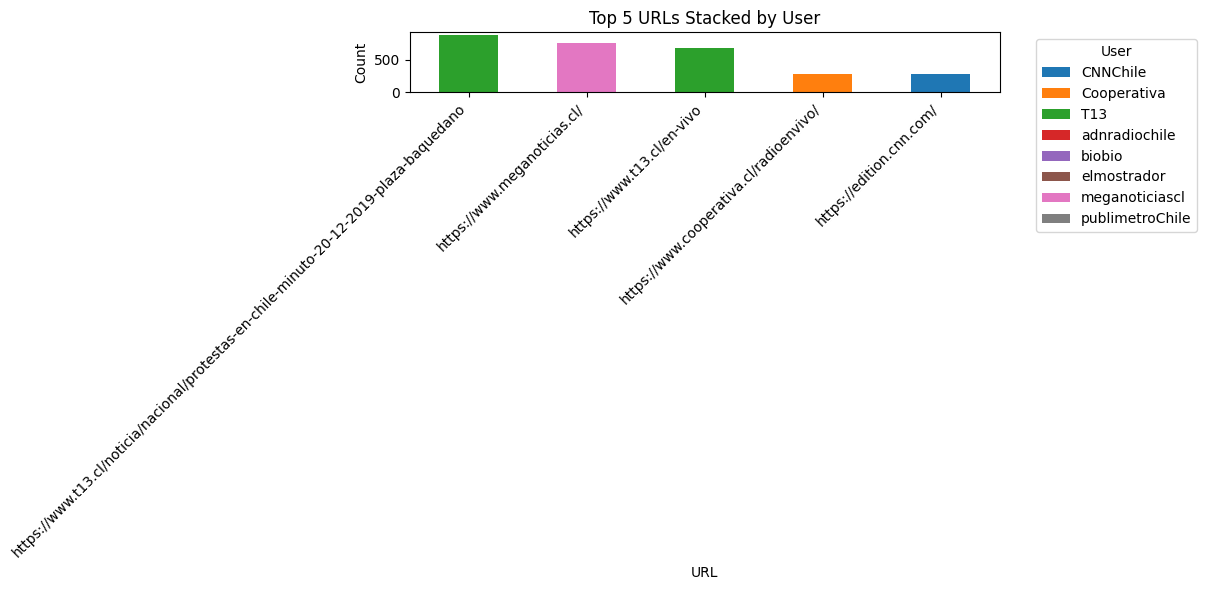

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_stacked_bar_chart(df, num_urls=5):
    """
    Plots a stacked bar chart of the most popular URLs, grouped by user.
    
    Parameters:
    - df: DataFrame with 'User' and 'URL' columns.
    - num_urls: Number of top URLs to display.
    """
    # Aggregate data
    url_counts = df.groupby(['URL', 'User']).size().unstack(fill_value=0)
    
    # Get the top N URLs
    top_urls = url_counts.sum(axis=1).nlargest(num_urls).index

    # Filter data for top URLs
    top_url_data = url_counts.loc[top_urls]

    # Plot
    top_url_data.plot(kind='bar', stacked=True, figsize=(12, 6))
    
    plt.title(f'Top {num_urls} URLs Stacked by User')
    plt.ylabel('Count')
    plt.xlabel('URL')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()

plot_stacked_bar_chart(df_url)


In [13]:
def display_url_presence_by_user(df):
    """
    Displays a table with binary indicators showing whether a user has tweeted a URL.
    
    Parameters:
    - df: DataFrame with 'User' and 'URL' columns.
    """
    # Ensure 'URL' is a string
    df['URL'] = df['URL'].astype(str)

    binary_table = pd.crosstab(df['URL'], df['User'])
    binary_table[binary_table > 0] = 1
    return binary_table

# Usage:
url_user_presence = display_url_presence_by_user(df_url)
url_user_presence


User                                                CNNChile  Cooperativa   
URL                                                                         
http://goleadorhistorico.alairelibre.cl/                   0            1  \
http://jugadordelafecha.alairelibre.cl/                    0            1   
http://programas.cooperativa.cl/loquequedadeldia/          0            1   
http://programas.cooperativa.cl/showalairelibre/           0            1   
http://programas.cooperativa.cl/unanuevamanana/...         0            1   
...                                                      ...          ...   
https://www.youtube.com/watch?v=xETTy0FJ1Nk                0            0   
https://www.youtube.com/watch?v=y5vvZ5gbF10                1            0   
https://www.youtube.com/watch?v=yElajfrBzOc                0            0   
https://www.youtube.com/watch?v=zdojudQMy2Q                0            0   
nan                                                        1            1   

User                                                T13  adnradiochile   
URL                                                                      
http://goleadorhistorico.alairelibre.cl/              0              0  \
http://jugadordelafecha.alairelibre.cl/               0              0   
http://programas.cooperativa.cl/loquequedadeldia/     0              0   
http://programas.cooperativa.cl/showalairelibre/      0              0   
http://programas.cooperativa.cl/unanuevamanana/...    0              0   
...                                                 ...            ...   
https://www.youtube.com/watch?v=xETTy0FJ1Nk           0              1   
https://www.youtube.com/watch?v=y5vvZ5gbF10           0              0   
https://www.youtube.com/watch?v=yElajfrBzOc           0              1   
https://www.youtube.com/watch?v=zdojudQMy2Q           0              1   
nan                                                   1              1   

User                                                biobio  elmostrador   
URL                                                                       
http://goleadorhistorico.alairelibre.cl/                 0            0  \
http://jugadordelafecha.alairelibre.cl/                  0            0   
http://programas.cooperativa.cl/loquequedadeldia/        0            0   
http://programas.cooperativa.cl/showalairelibre/         0            0   
http://programas.cooperativa.cl/unanuevamanana/...       0            0   
...                                                    ...          ...   
https://www.youtube.com/watch?v=xETTy0FJ1Nk              0            0   
https://www.youtube.com/watch?v=y5vvZ5gbF10              0            0   
https://www.youtube.com/watch?v=yElajfrBzOc              0            0   
https://www.youtube.com/watch?v=zdojudQMy2Q              0            0   
nan                                                      1            1   

User                                                meganoticiascl   
URL                                                                  
http://goleadorhistorico.alairelibre.cl/                         0  \
http://jugadordelafecha.alairelibre.cl/                          0   
http://programas.cooperativa.cl/loquequedadeldia/                0   
http://programas.cooperativa.cl/showalairelibre/                 0   
http://programas.cooperativa.cl/unanuevamanana/...               0   
...                                                            ...   
https://www.youtube.com/watch?v=xETTy0FJ1Nk                      0   
https://www.youtube.com/watch?v=y5vvZ5gbF10                      0   
https://www.youtube.com/watch?v=yElajfrBzOc                      0   
https://www.youtube.com/watch?v=zdojudQMy2Q                      0   
nan                                                              1   

User                                                publimetroChile  
URL                                                                  
http://g

In [14]:
# URLs mentioned by multiple users:
url_user_presence[url_user_presence.sum(axis=1) > 1]

User                                                CNNChile  Cooperativa   
URL                                                                         
https://twitter.com/Ejercito_Chile/status/11856...         0            0  \
https://twitter.com/Transantiago/status/1187495...         0            1   
https://twitter.com/UOCT_RM/status/118775022468...         0            0   
nan                                                        1            1   

User                                                T13  adnradiochile   
URL                                                                      
https://twitter.com/Ejercito_Chile/status/11856...    1              1  \
https://twitter.com/Transantiago/status/1187495...    0              0   
https://twitter.com/UOCT_RM/status/118775022468...    1              0   
nan                                                   1              1   

User                                                biobio  elmostrador   
URL                                                                       
https://twitter.com/Ejercito_Chile/status/11856...       0            0  \
https://twitter.com/Transantiago/status/1187495...       0            0   
https://twitter.com/UOCT_RM/status/118775022468...       1            0   
nan                                                      1            1   

User                                                meganoticiascl   
URL                                                                  
https://twitter.com/Ejercito_Chile/status/11856...               0  \
https://twitter.com/Transantiago/status/1187495...               1   
https://twitter.com/UOCT_RM/status/118775022468...               0   
nan                                                              1   

User                                                publimetroChile  
URL                                                                  
https://twitter.com/Ejercito_Chile/status/11856...                0  
https://twitter.com/Transantiago/status/1187495...                0  
https://twitter.com/UOCT_RM/status/118775022468...                0  
nan                                                               1

/tmp/ipykernel_23797/1997819645.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


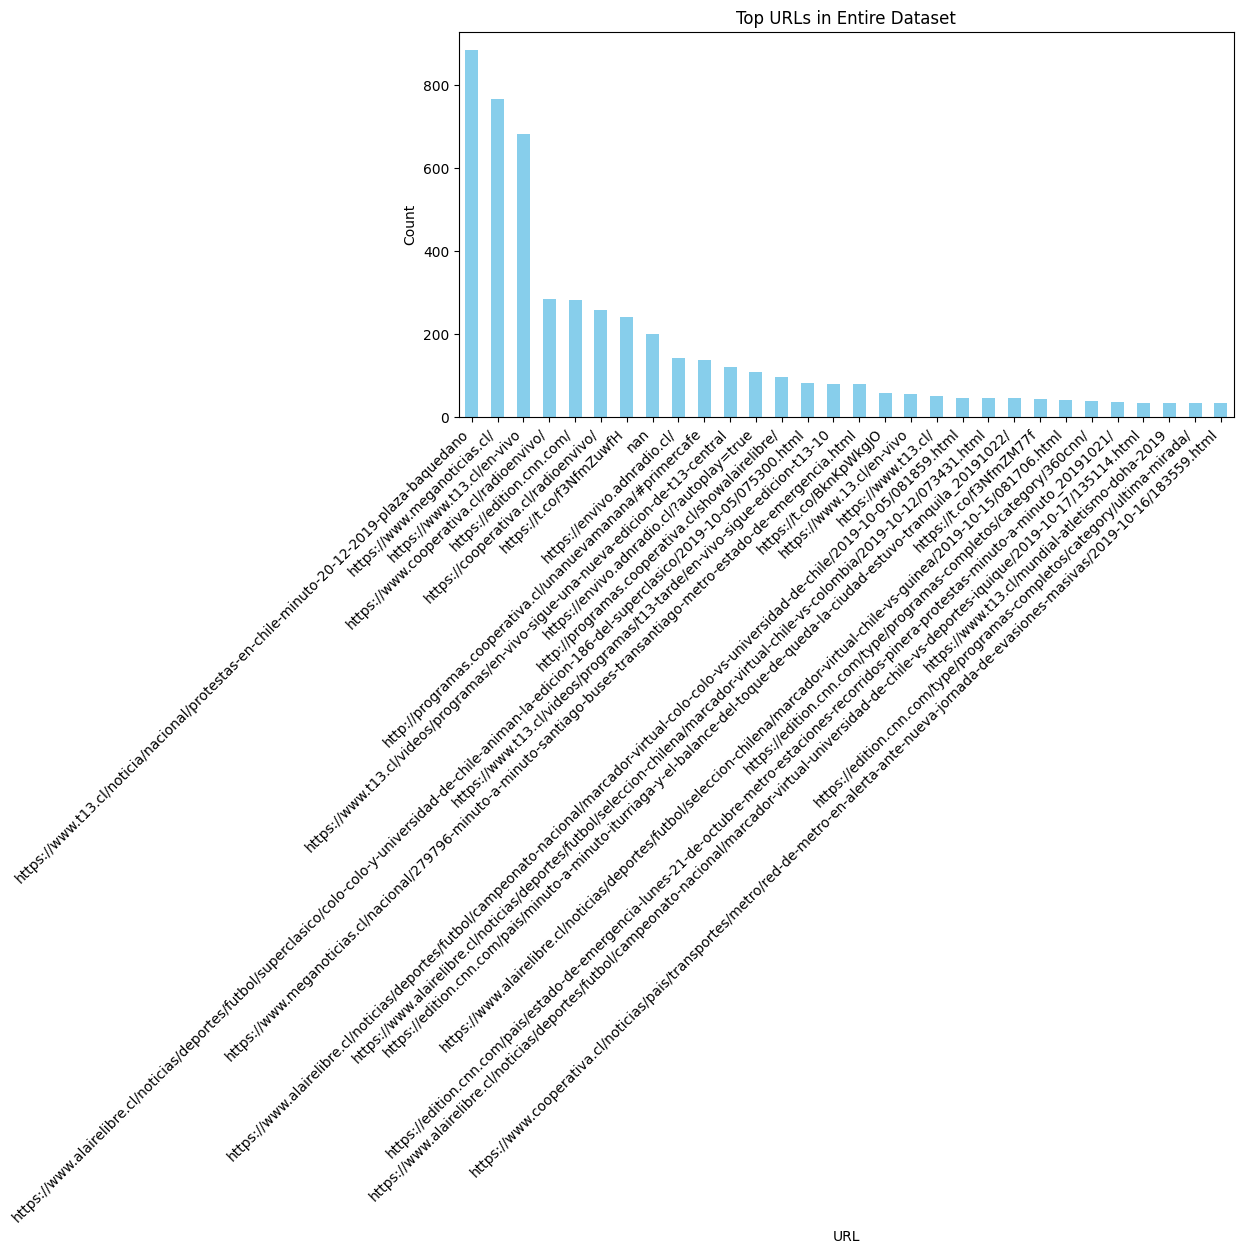

In [15]:
def plot_total_url_counts(url_df, num_urls=30):
    """
    Plots the top URLs in the entire dataset.
    
    Parameters:
    - url_df: DataFrame with 'URLs' column.
    - num_urls: Number of top URLs to display.
    """
    plt.figure(figsize=(10, 5))
    url_df['URL'].value_counts().head(num_urls).plot(kind='bar', color='skyblue')
    plt.title('Top URLs in Entire Dataset')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_total_url_counts(df_url)

/tmp/ipykernel_23797/2838547224.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


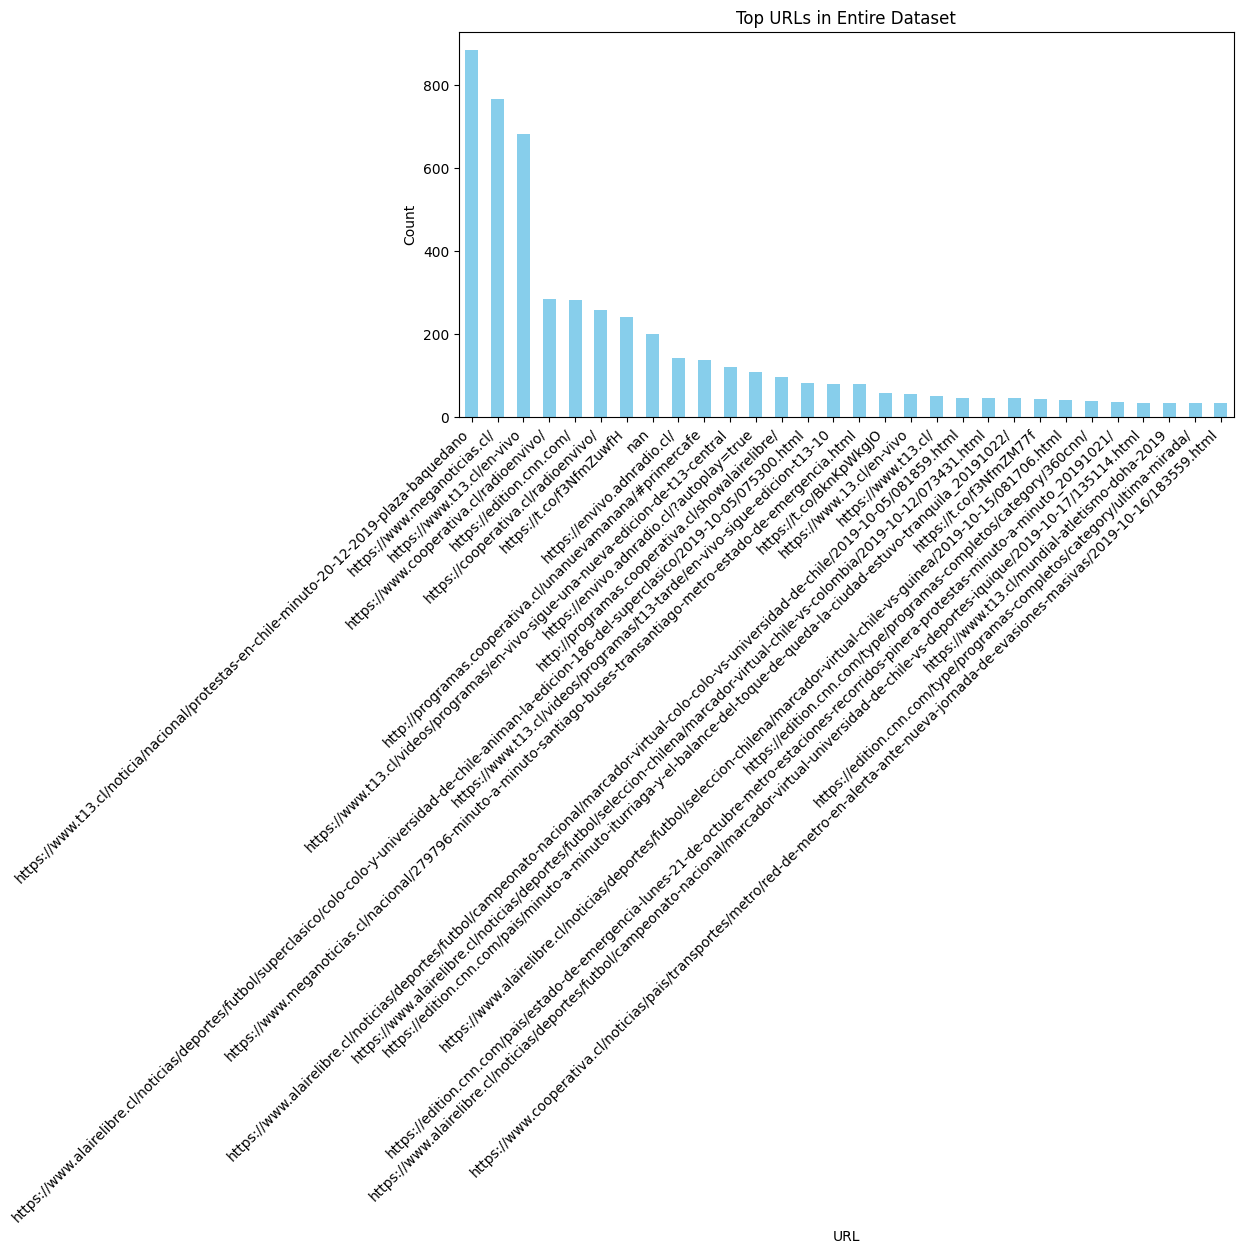

/tmp/ipykernel_23797/2838547224.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


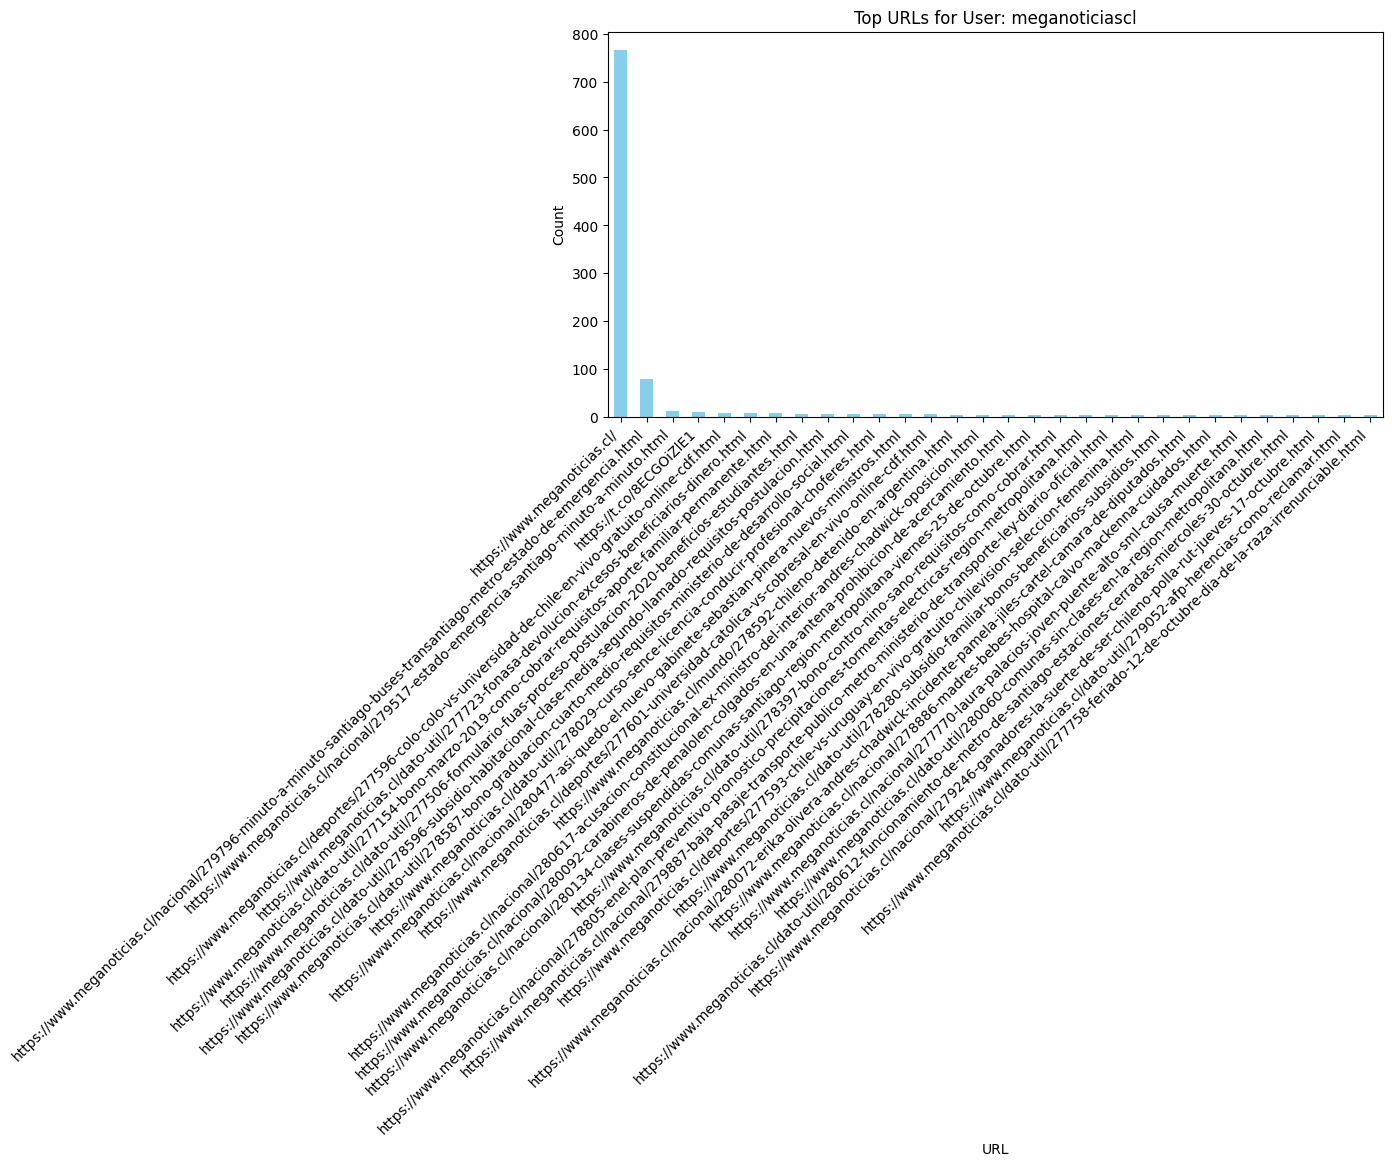

/tmp/ipykernel_23797/2838547224.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


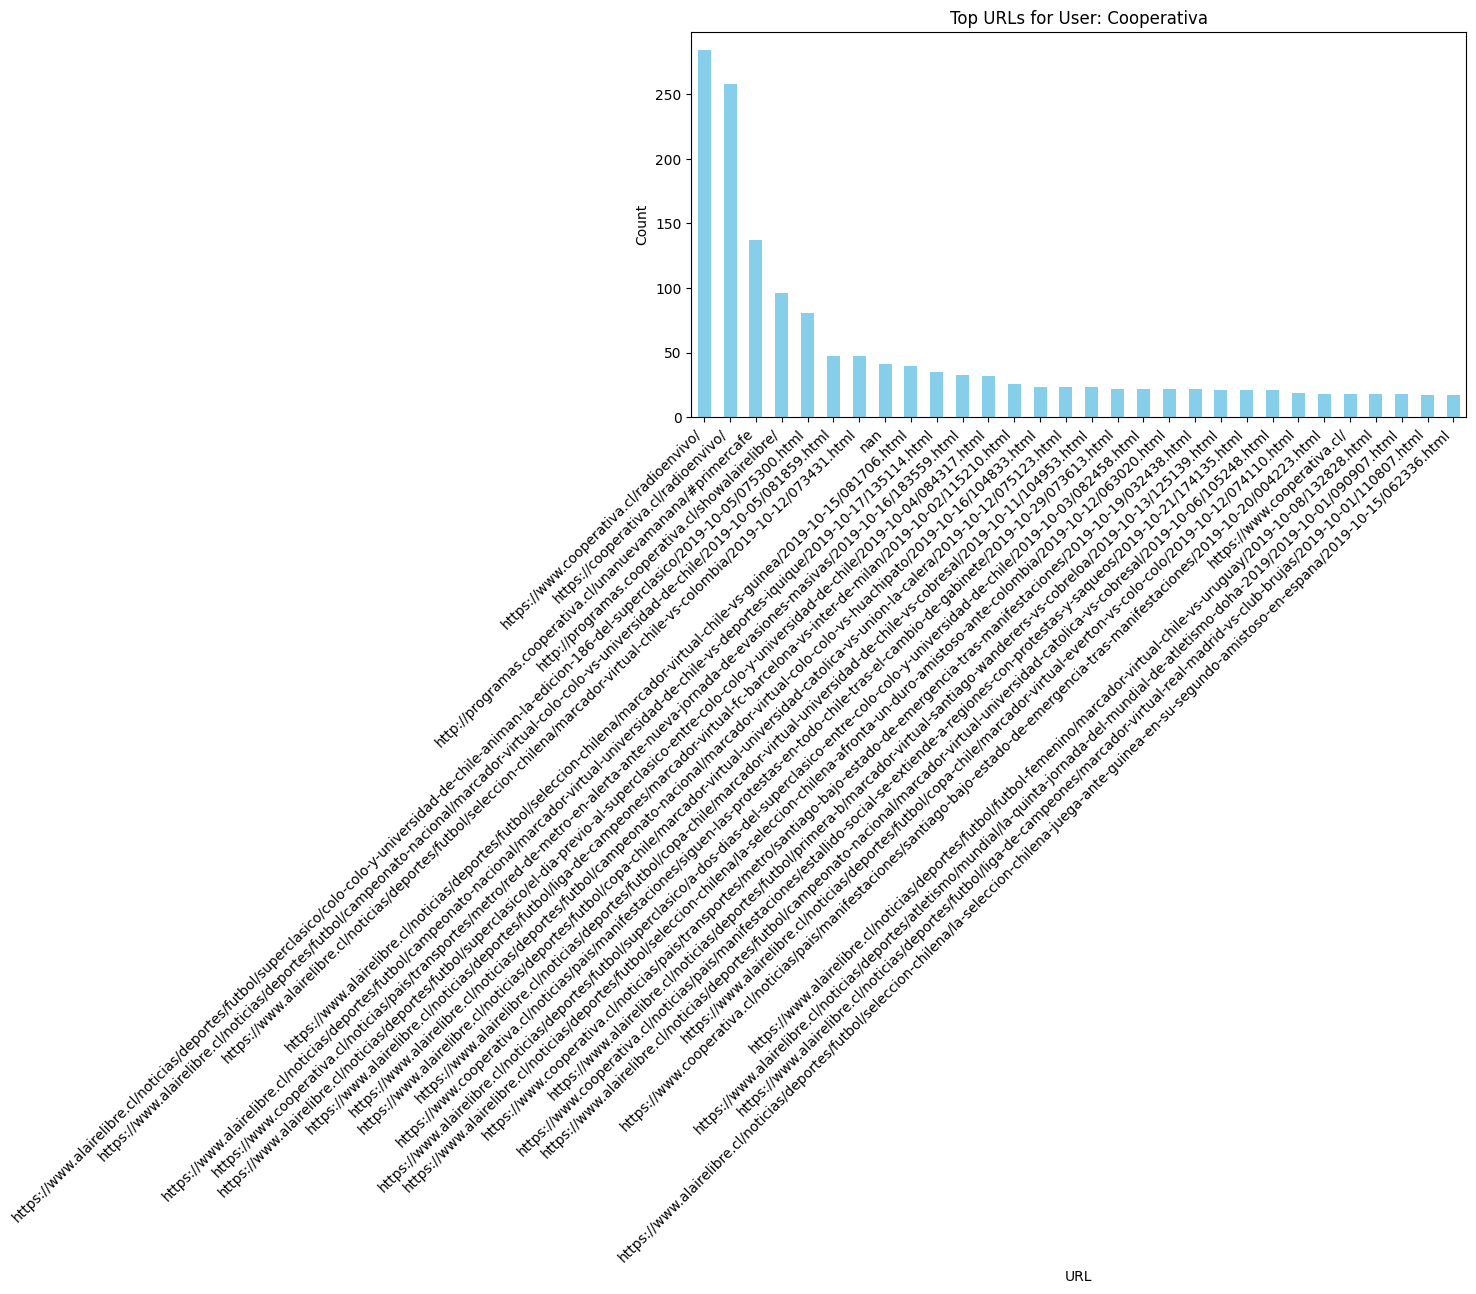

/tmp/ipykernel_23797/2838547224.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


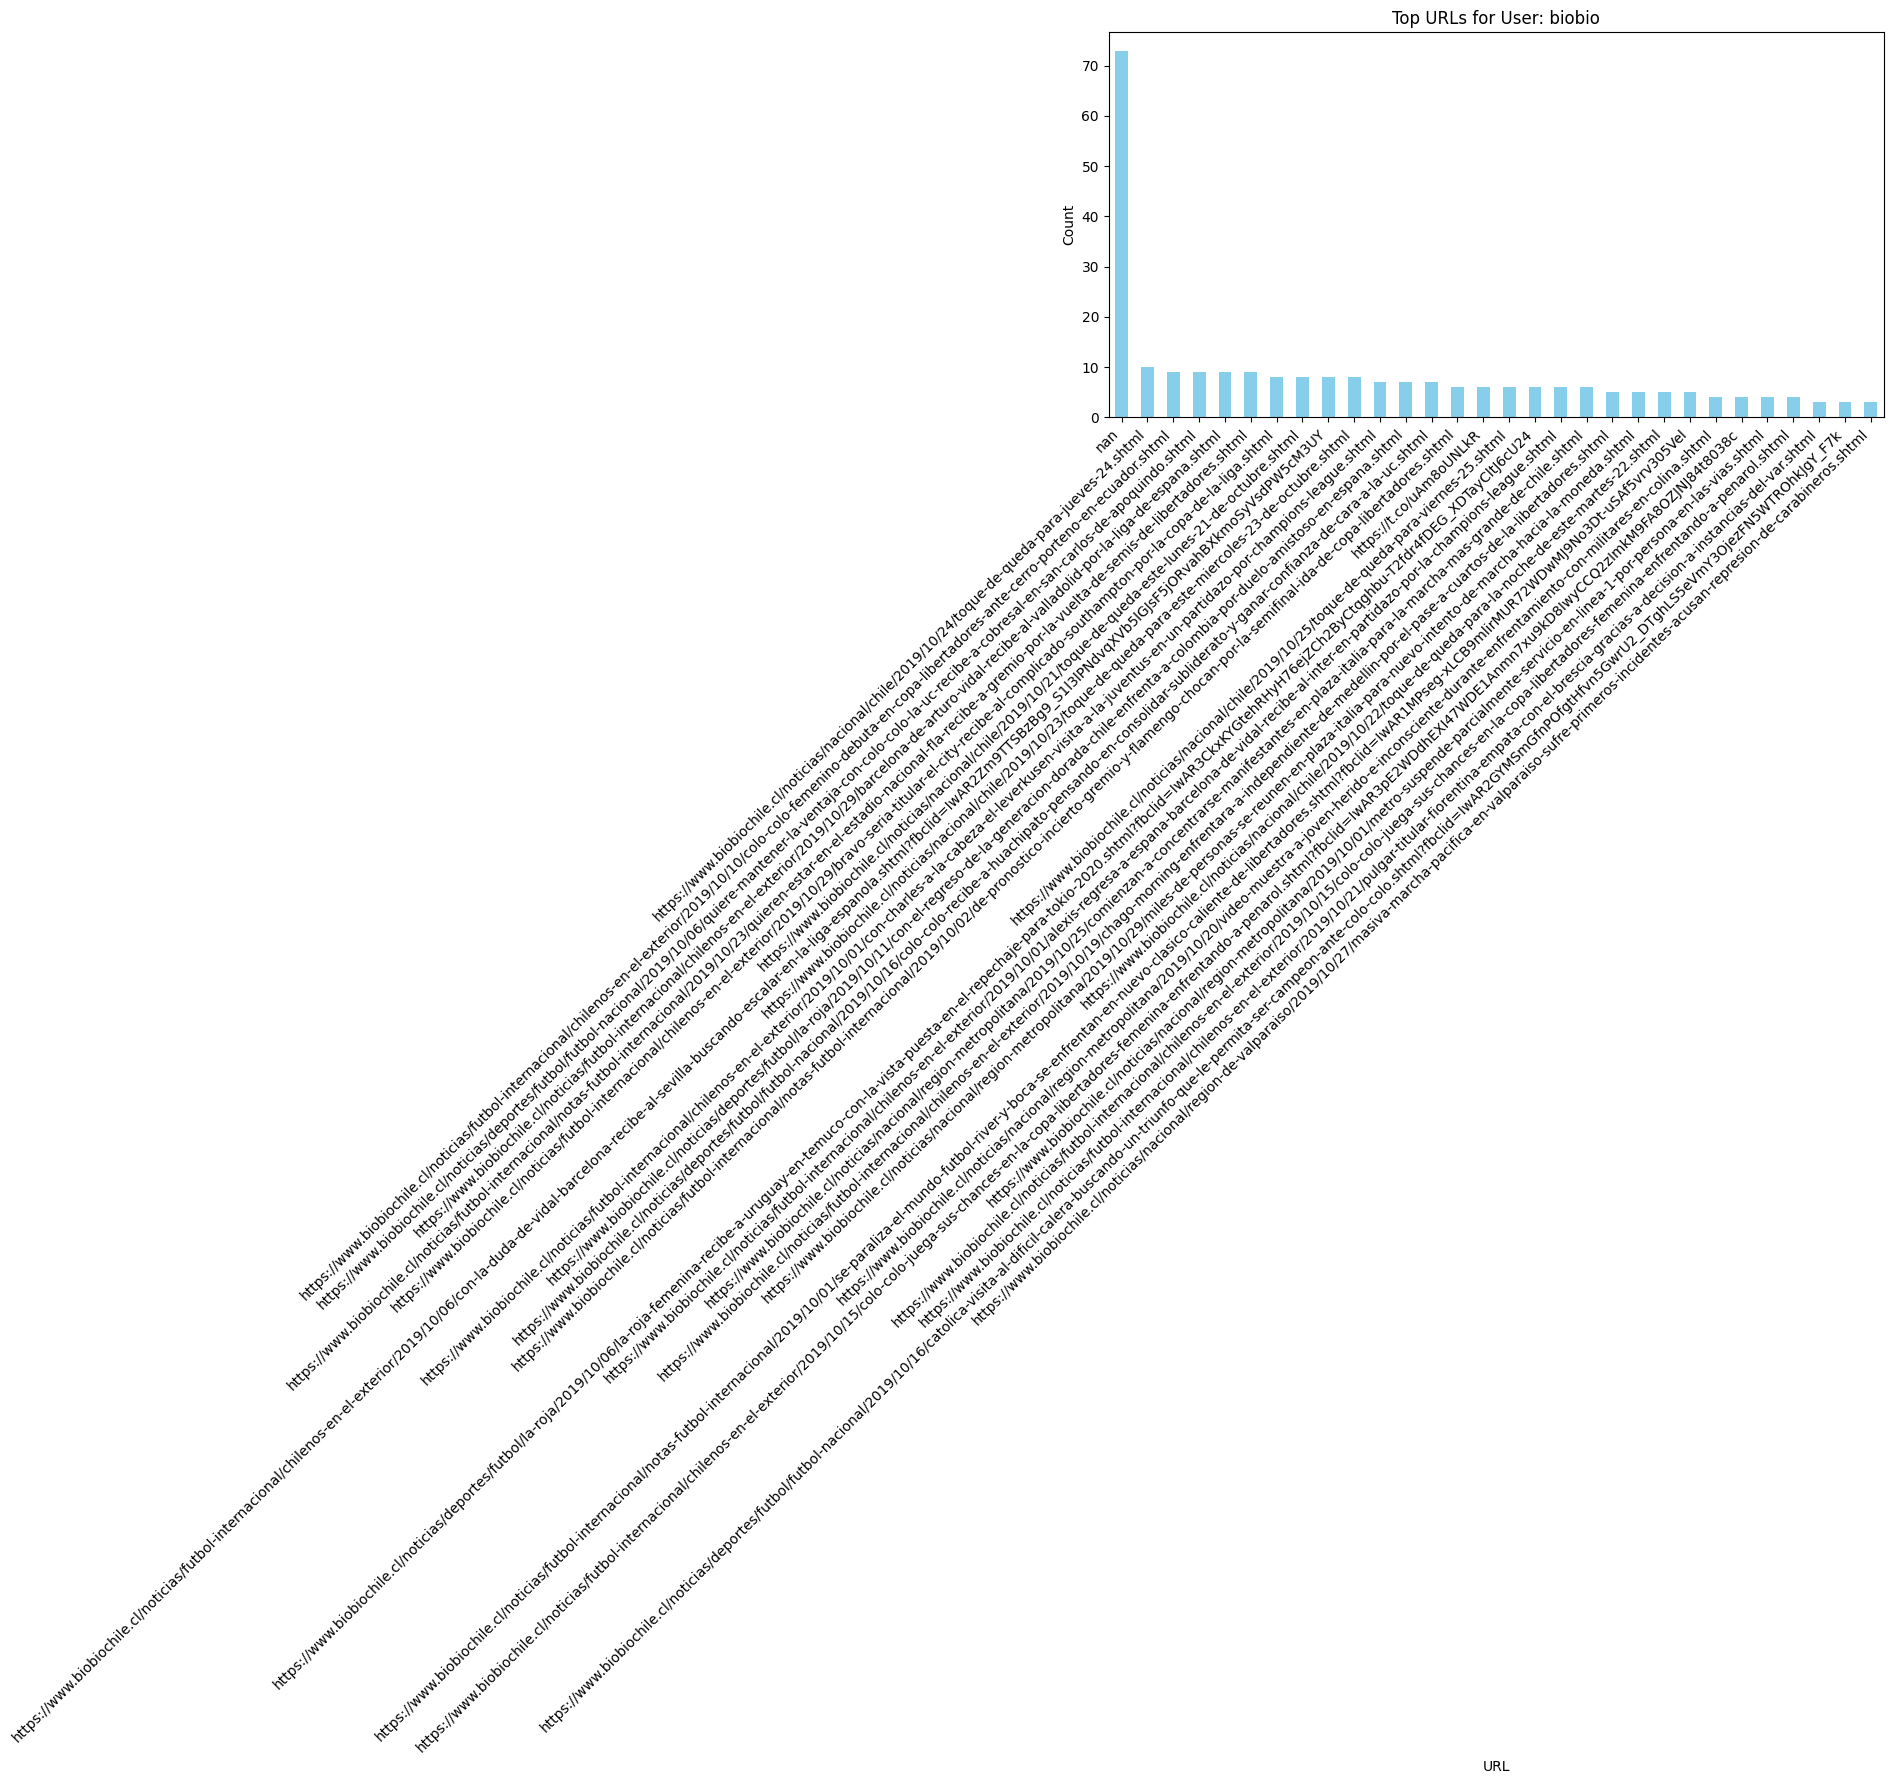

/tmp/ipykernel_23797/2838547224.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


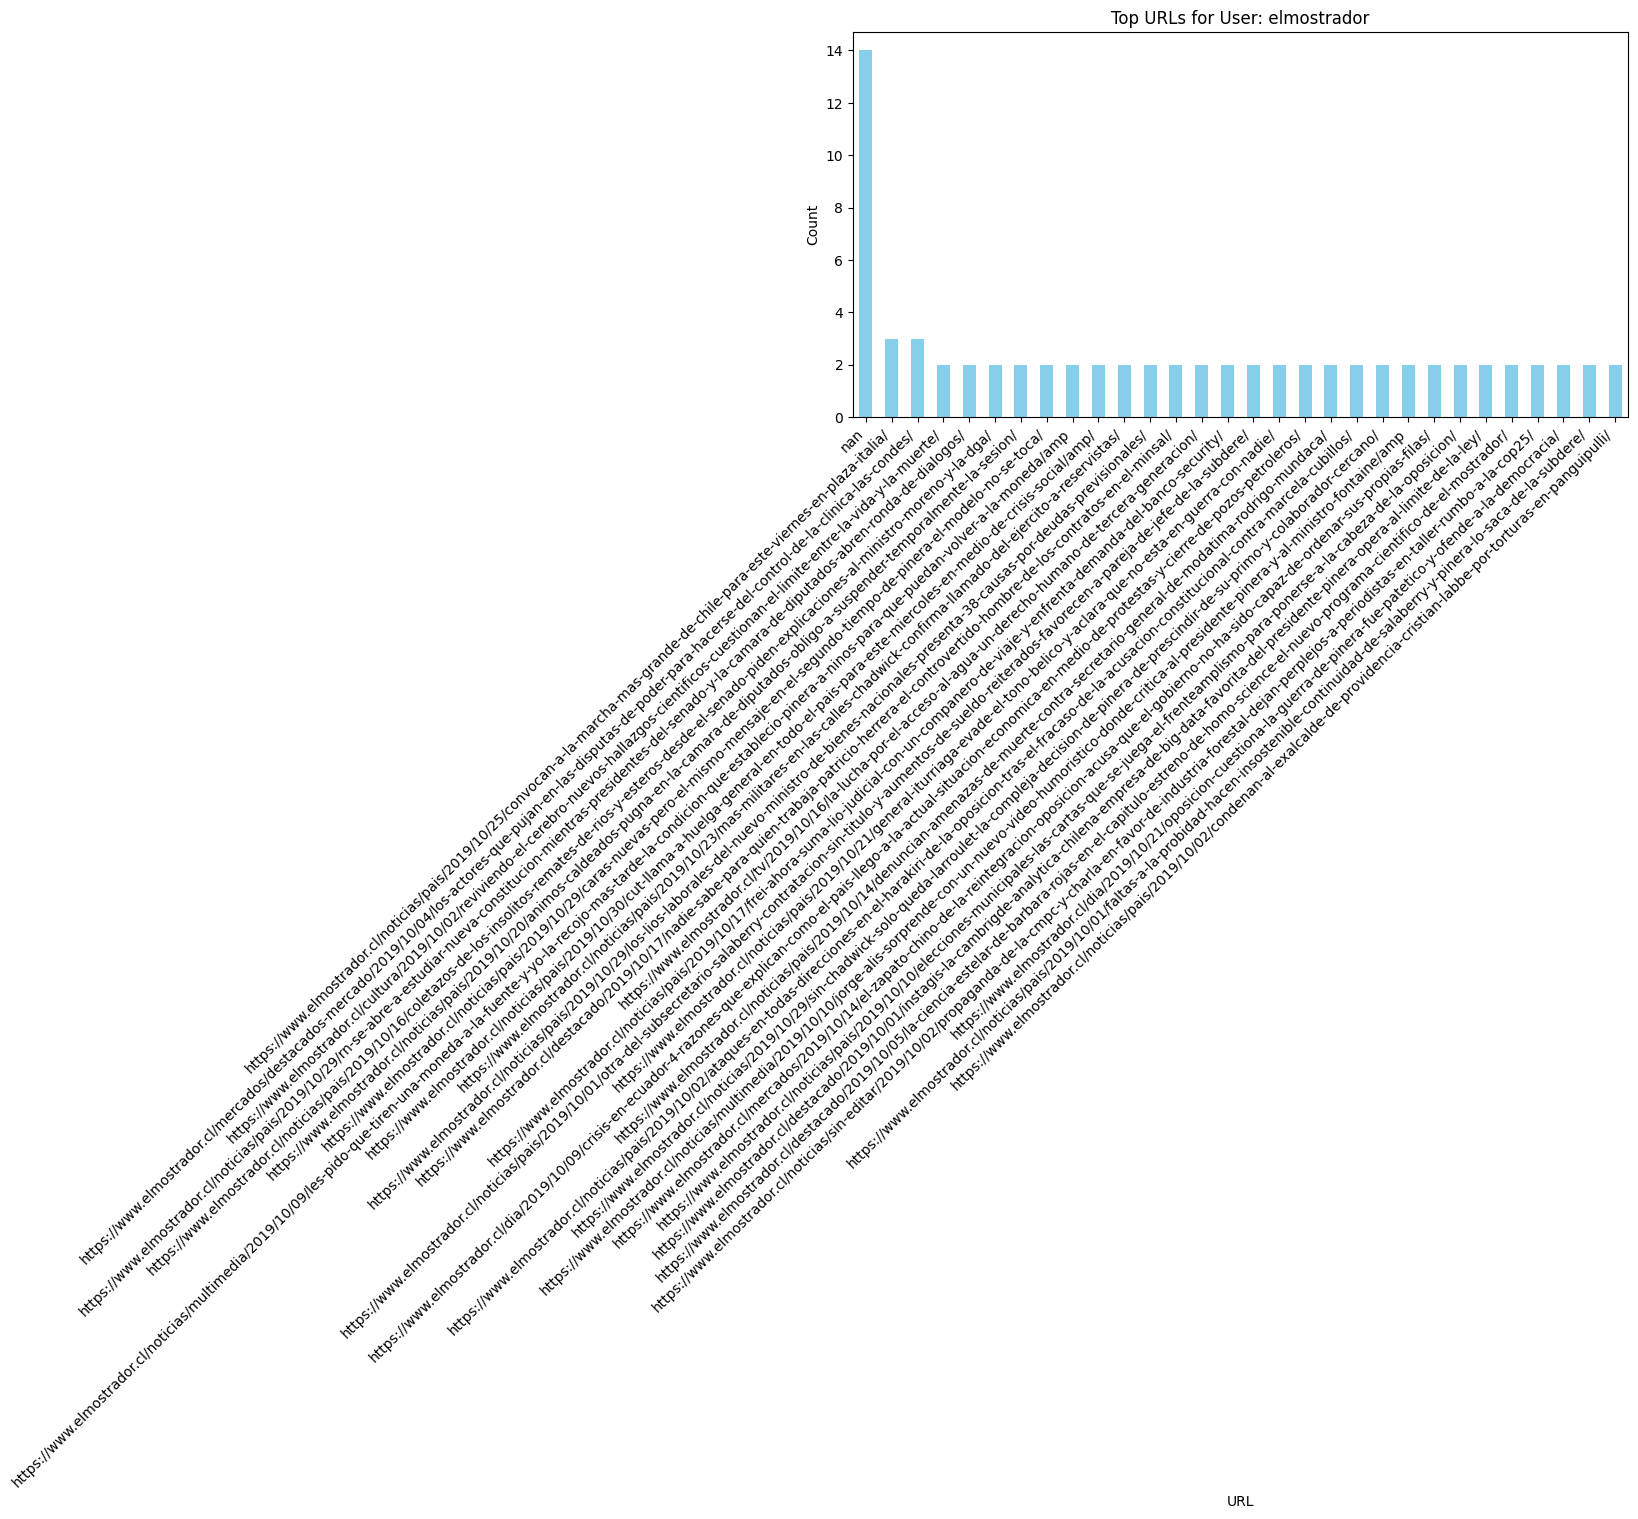

/tmp/ipykernel_23797/2838547224.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


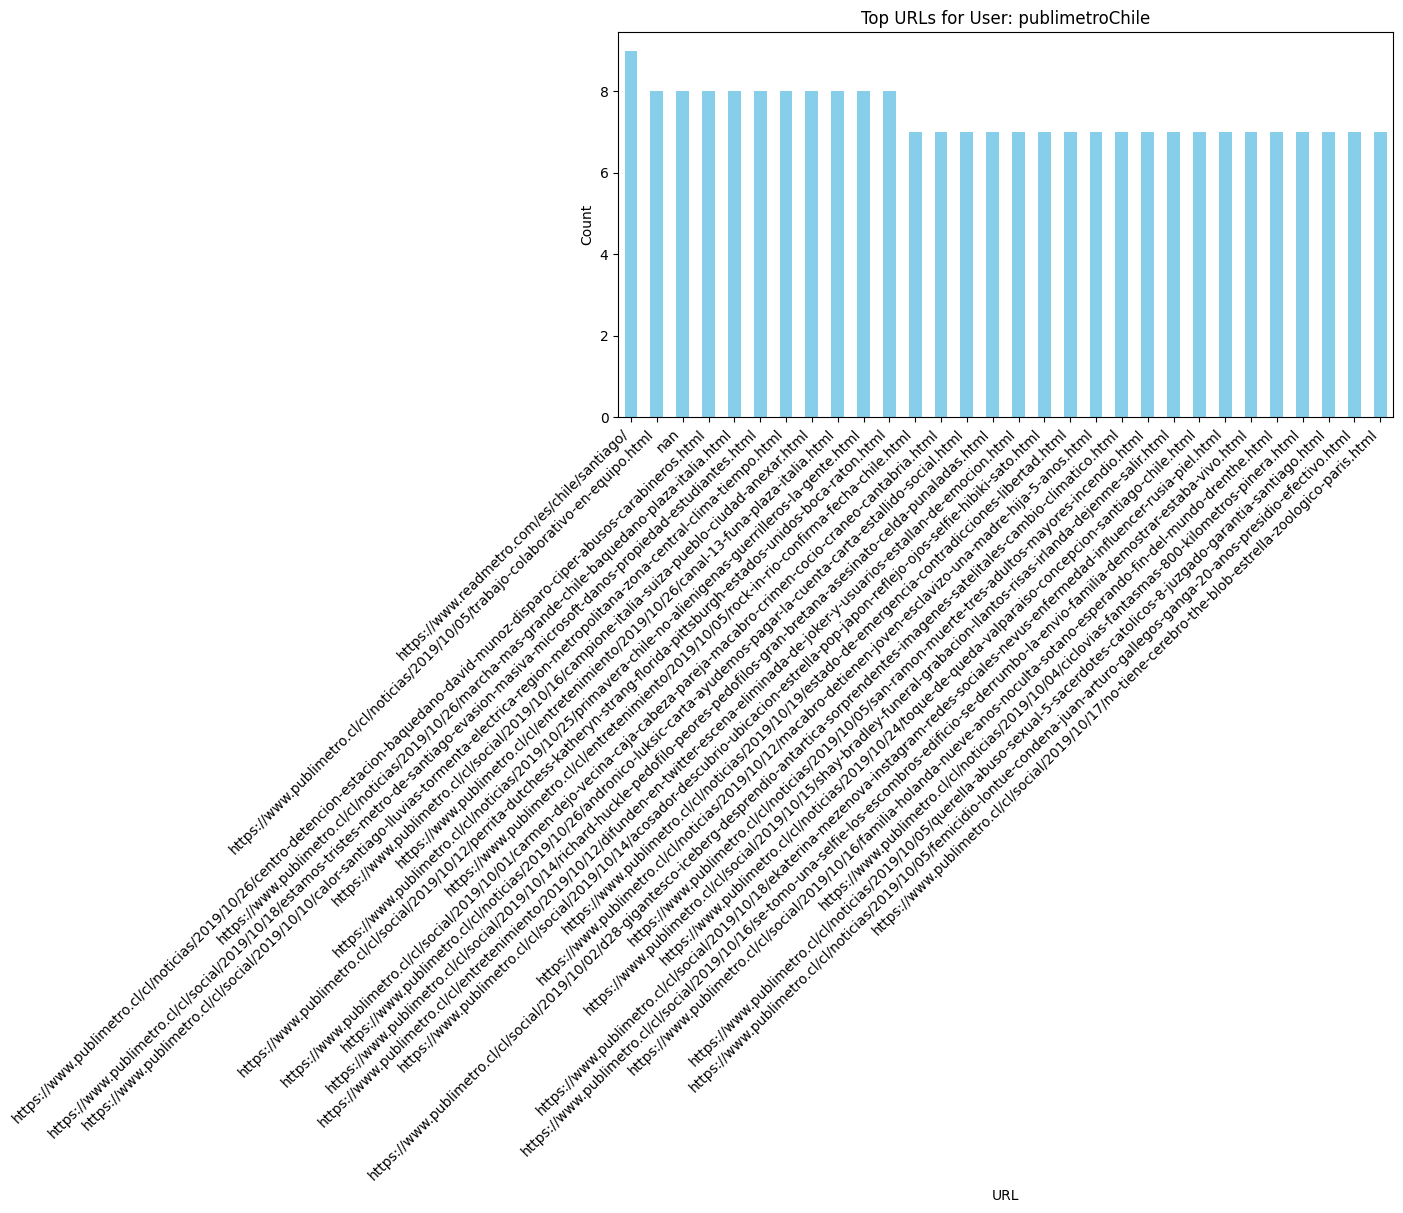

/tmp/ipykernel_23797/2838547224.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


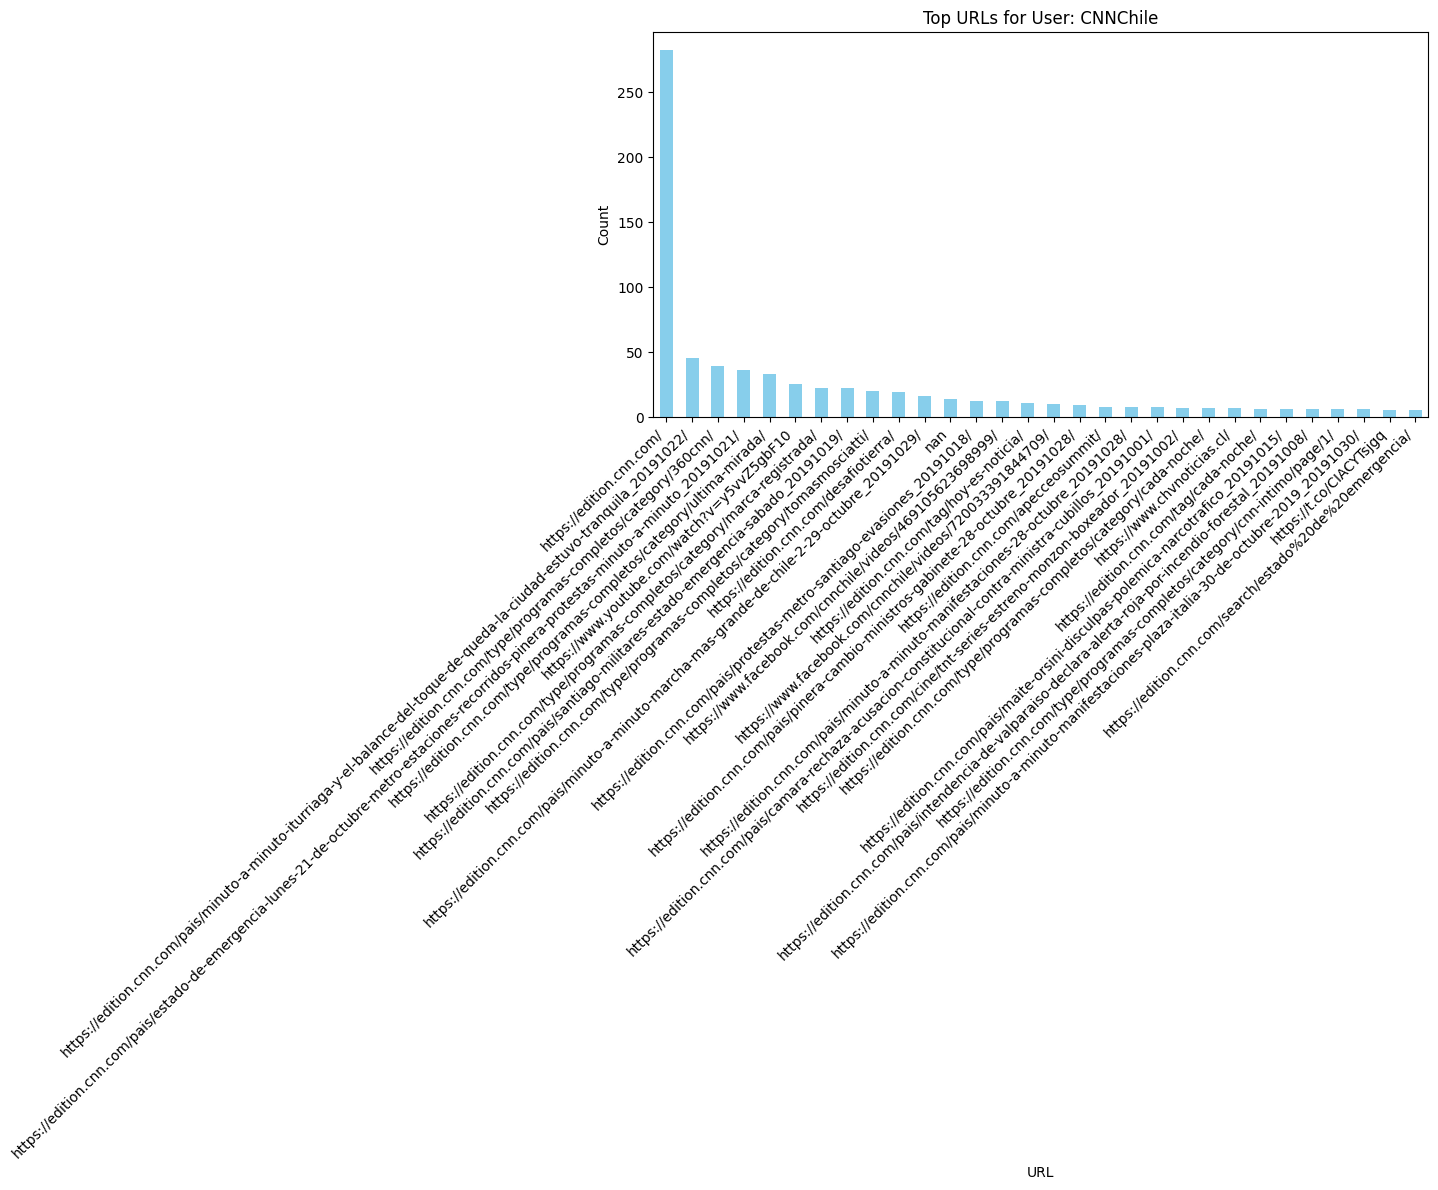

/tmp/ipykernel_23797/2838547224.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


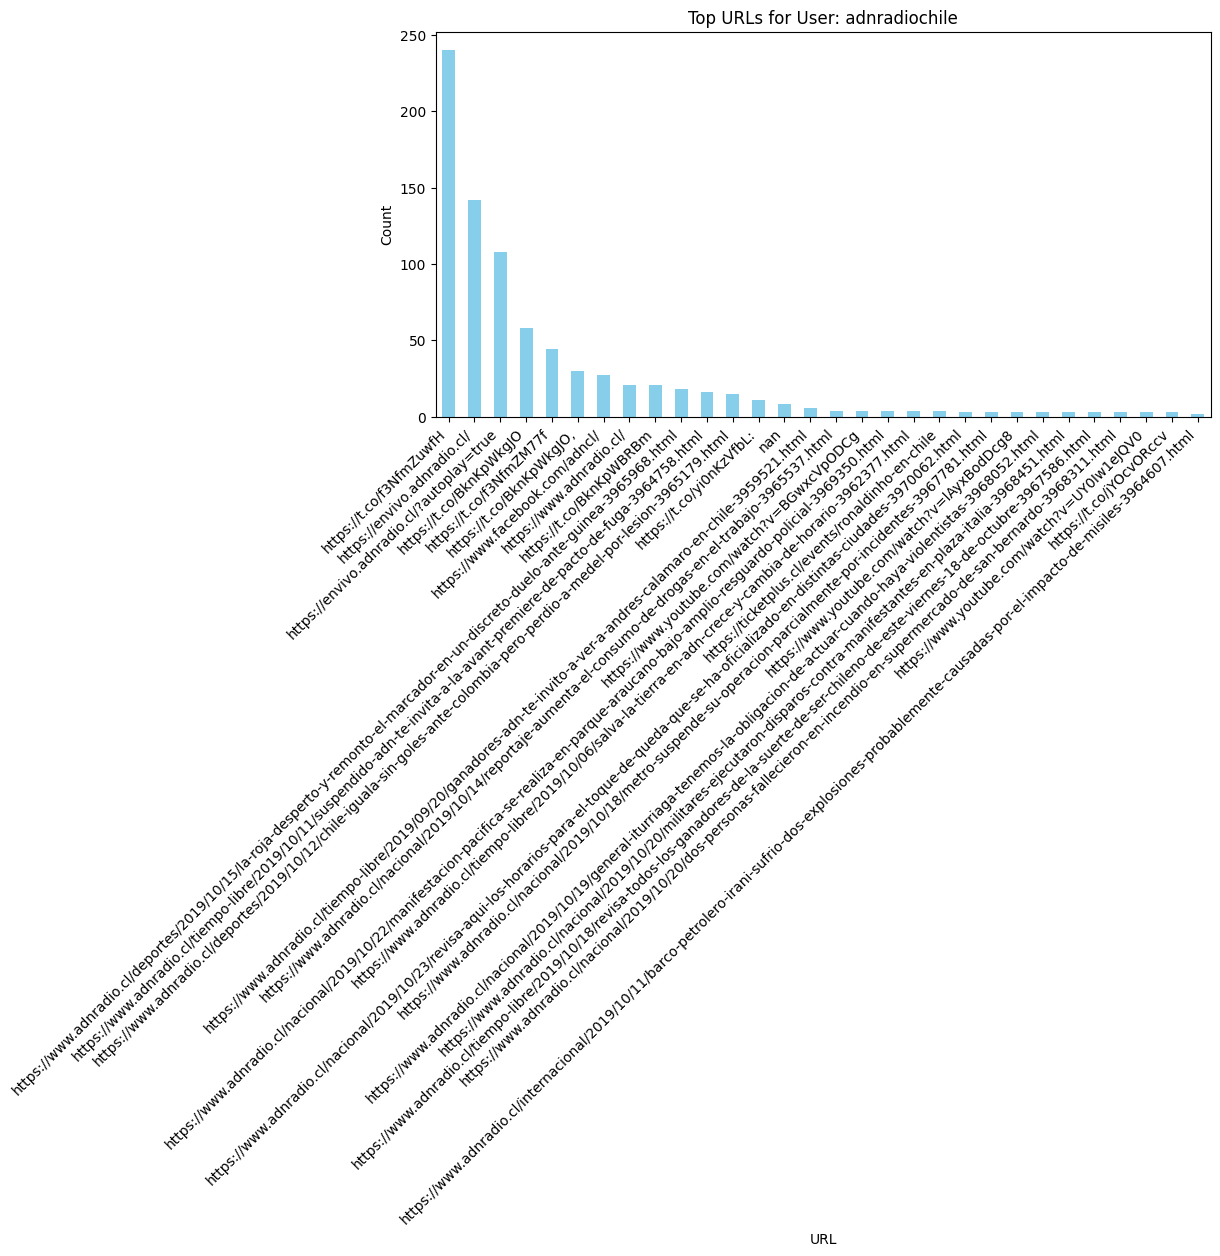

/tmp/ipykernel_23797/2838547224.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


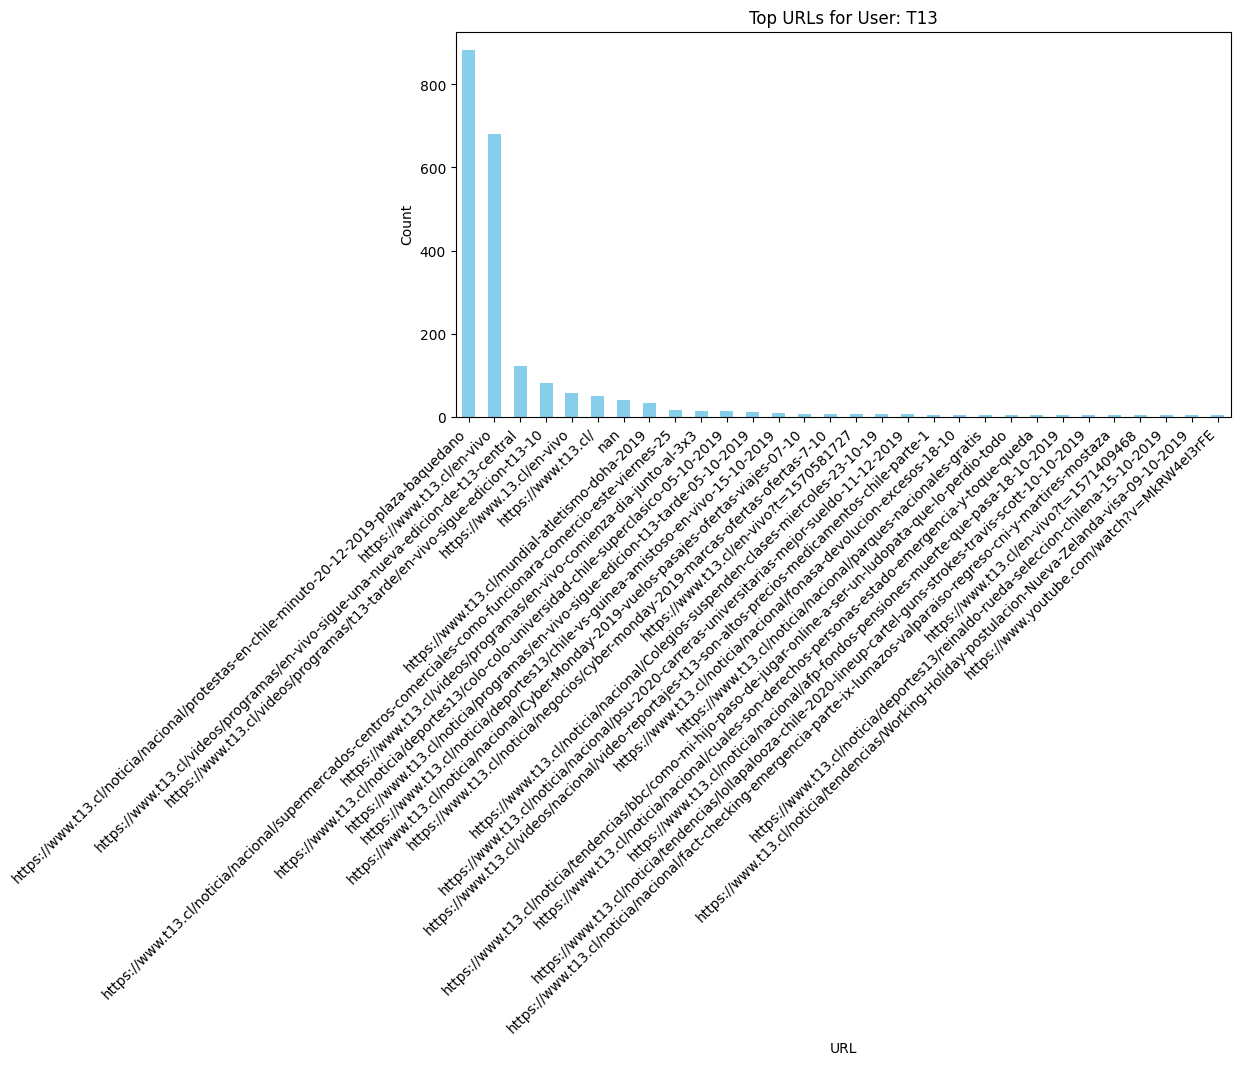

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_urls(df, num_urls=5):
    """
    Plots the top URLs in the 'URL' column of the dataframe, both for the entire dataset and per user.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with a 'URL' column containing URLs and a 'User' column for user names.
    - num_urls (int): Number of top URLs to display.
    """

    # Plot for the entire dataset
    plt.figure(figsize=(10, 5))
    if not df['URL'].isnull().all():  # Check if there are any URLs
        df['URL'].value_counts().head(num_urls).plot(kind='bar', color='skyblue')
        plt.title('Top URLs in Entire Dataset')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No URLs to display for the entire dataset.")

    # Plot for each user
    for user in df['User'].unique():
        user_data = df[df['User'] == user]
        if not user_data['URL'].isnull().all():  # Check if the user has any URLs
            plt.figure(figsize=(10, 5))
            user_data['URL'].value_counts().head(num_urls).plot(kind='bar', color='skyblue')
            plt.title(f'Top URLs for User: {user}')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No URLs to display for user: {user}")

# Example usage
# df = [Your DataFrame with 'URL' and 'User' columns]
plot_top_urls(df_url, num_urls=30)


In [17]:

def print_top_urls(df, num_urls=5):
    """
    Prints the top URLs in the 'URL' column of the dataframe, both for the entire dataset and per user.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with a 'URL' column containing URLs and a 'User' column for user names.
    - num_urls (int): Number of top URLs to display.
    """

    # Print value counts for the entire dataset
    print("Top URLs in Entire Dataset:")
    print(df['URL'].value_counts().head(num_urls))

    # Print value counts for each user
    for user in df['User'].unique():
        print(f"\nTop URLs for User: {user}")
        user_data = df[df['User'] == user]
        print(user_data['URL'].value_counts().head(num_urls))

print_top_urls(df_url, num_urls=30)


Top URLs in Entire Dataset:
URL
https://www.t13.cl/noticia/nacional/protestas-en-chile-minuto-20-12-2019-plaza-baquedano                                                                           883
https://www.meganoticias.cl/                                                                                                                                       767
https://www.t13.cl/en-vivo                                                                                                                                         681
https://www.cooperativa.cl/radioenvivo/                                                                                                                            284
https://edition.cnn.com/                                                                                                                                           282
https://cooperativa.cl/radioenvivo/                                                                                                  